In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(42)

### Analisi Esplorativa dei dati

In [2]:
df = pandas.read_csv('data/theft_df.csv')

display(df)
df.describe()

,geo,year,theft,poverty,neet,education,unemployment,income,inequity
0,Austria,2016,1651.67,14.964810,8.091438,34.540870,3.828207,62.528811,4.09
1,Belgium,2016,2055.54,25.110680,13.799563,50.108248,5.316225,60.783882,3.85
2,Bulgaria,2016,457.48,29.330514,16.024476,23.464412,3.648430,32.978295,7.69
3,Cyprus,2016,86.17,1.917201,1.526974,4.767553,0.729554,52.772737,4.88
4,Czechia,2016,674.86,13.086765,11.714766,34.405528,2.743999,43.974128,3.50
...,...,...,...,...,...,...,...,...,...
157,Portugal,2021,621.02,23.068084,9.783339,48.916697,4.531231,48.953165,5.66
158,Romania,2021,471.44,66.245734,38.979374,44.739872,6.144532,37.809305,7.14
159,Sweden,2021,2784.26,17.852387,6.227577,51.169924,6.746542,63.711278,4.04
160,Slovenia,2021,634.76,2.783850,1.539553,10.102000,0.653783,54.222503,3.24


,year,theft,poverty,neet,education,unemployment,income,inequity
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,2018.500000,1091.711914,36.320591,23.064795,64.467123,8.095696,52.712330,4.844383
std,1.713121,855.293949,48.065890,34.141798,84.069332,12.501566,10.340572,1.202327
min,2016.000000,57.770000,0.892976,0.347262,1.544923,0.114168,30.526920,3.030000
25%,2017.000000,457.022500,7.893735,3.570964,14.613305,1.431114,44.140811,4.042500
50%,2018.500000,819.780000,14.914794,8.182723,29.957130,2.847736,53.328431,4.435000
75%,2020.000000,1563.250000,30.007613,18.667848,51.700525,6.701091,62.307751,5.727500
max,2021.000000,3951.310000,174.625565,148.023944,339.452221,59.443327,74.903505,8.230000


<Axes: >

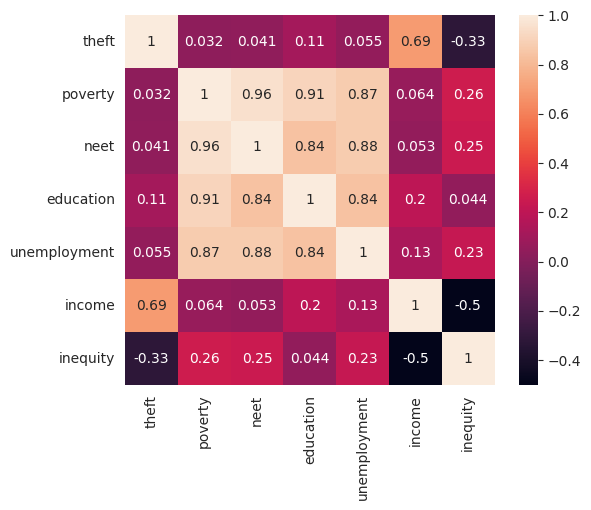

In [3]:
# Correlation Matrix
corrmat = df.drop(columns=["geo", "year"]).corr()

sns.heatmap(corrmat, square=True, annot=True)

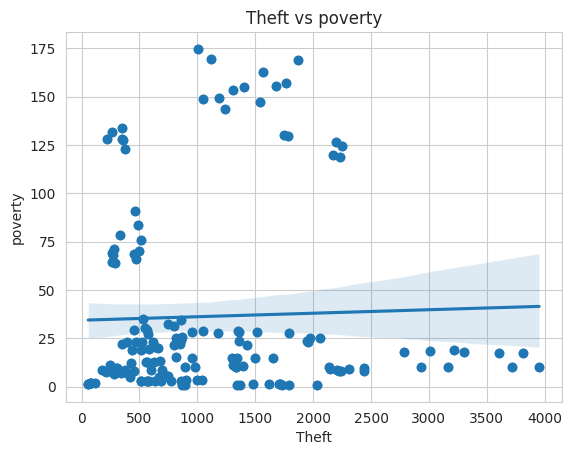

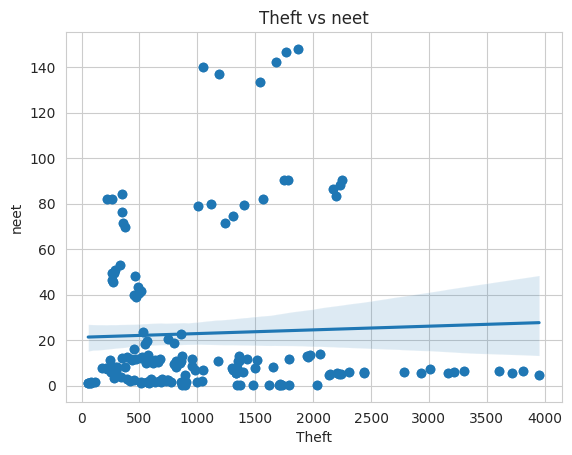

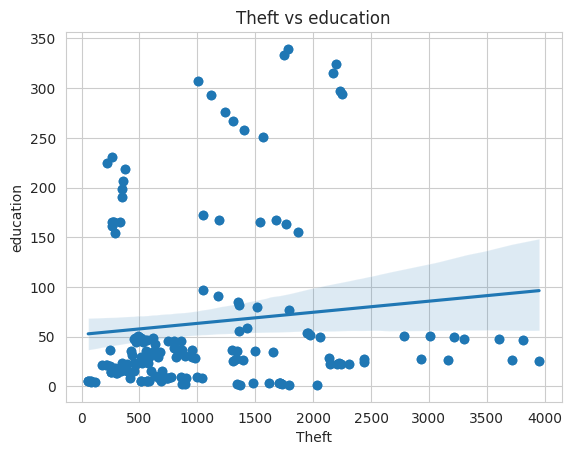

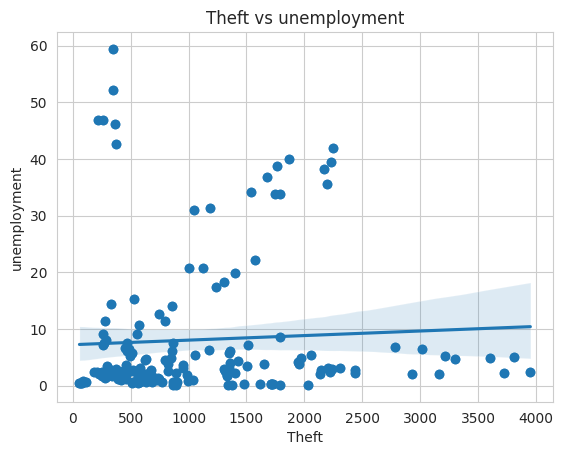

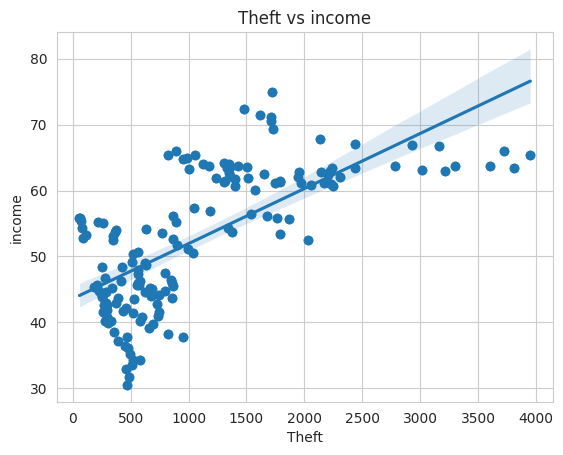

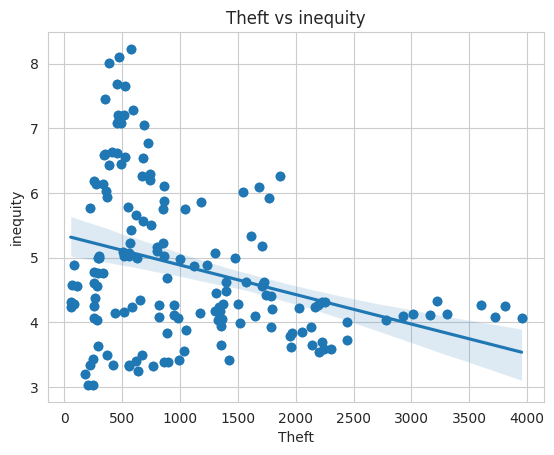

In [4]:
# Scatter Plot
features = ["poverty", "neet", "education", "unemployment", "income", "inequity"]

for feature in features:
    sns.regplot(x="theft", y=feature, data=df)
    plt.scatter(df["theft"], df[feature])
    plt.xlabel("Theft")
    plt.ylabel(feature)
    plt.title("Theft vs " + feature)
    plt.show()

# Modeling

In [5]:
X = df.drop(columns=["geo", "year", "theft"])
y = df["theft"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.40867356888037387

In [6]:
# ANOVA Model
model = ols("theft ~ poverty + neet + education + unemployment + income + inequity", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq     df           F        PR(>F)
poverty       1.754346e+05    1.0    0.449978  5.033437e-01
neet          6.454076e+05    1.0    1.655428  2.001401e-01
education     3.646373e+04    1.0    0.093527  7.601506e-01
unemployment  6.933412e+05    1.0    1.778374  1.843055e-01
income        4.255723e+07    1.0  109.156491  1.123550e-19
inequity      2.248353e+05    1.0    0.576688  4.487670e-01
Residual      6.043041e+07  155.0         NaN           NaN


In [7]:
X2 = sm.add_constant(df.drop(columns=["geo", "year", "theft"]))
model = sm.OLS(y, X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  theft   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     24.51
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           2.64e-20
Time:                        14:22:06   Log-Likelihood:                -1269.0
No. Observations:                 162   AIC:                             2552.
Df Residuals:                     155   BIC:                             2574.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2277.7152    488.653     -4.661   

In [8]:
hypothesis_0 = "poverty = 0, neet = 0, education = 0,  unemployment = 0, income = 0, inequity = 0"
print(results.t_test(hypothesis_0))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -3.5746      5.329     -0.671      0.503     -14.101       6.952
c1             7.2845      5.662      1.287      0.200      -3.899      18.468
c2             0.5572      1.822      0.306      0.760      -3.042       4.156
c3           -12.2929      9.218     -1.334      0.184     -30.502       5.916
c4            60.4575      5.787     10.448      0.000      49.027      71.888
c5            42.9333     56.536      0.759      0.449     -68.747     154.614


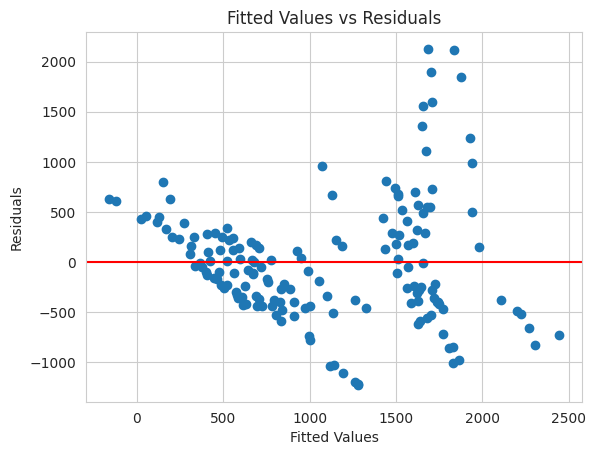

In [9]:
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs Residuals")
plt.axhline(y=0, color="red")
plt.show()

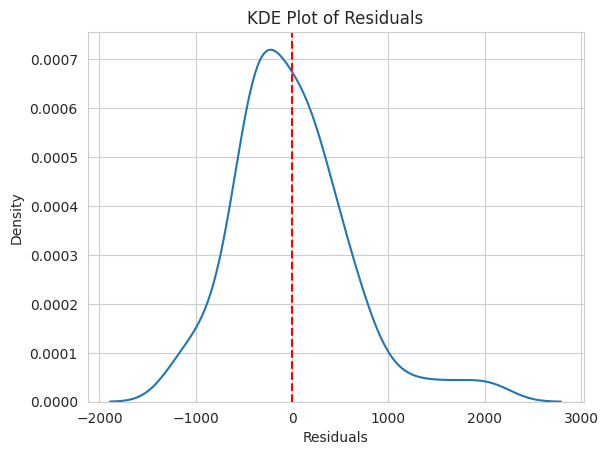

In [10]:
# KDE Plot of residuals
sns.kdeplot(results.resid)
plt.axvline(results.resid.mean(), linestyle='dashed', color="red")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("KDE Plot of Residuals")
plt.show()

### Top 5 regions with the highest theft in total

In [11]:
data = df.drop(columns=["poverty", "neet", "education", "income", "inequity"])
display(data.groupby("geo").sum().sort_values(by="theft", ascending=False).head(5))

,year,theft,unemployment
geo,,,
Sweden,12111,19729.23,33.045199
Denmark,12111,18336.99,13.068319
Finland,12111,13562.49,17.199486
France,12111,12376.76,222.754406
Belgium,12111,10716.08,26.389722


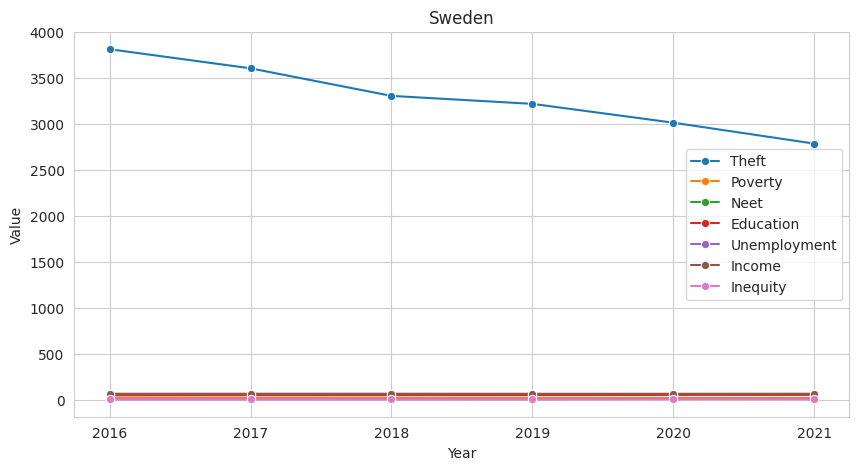

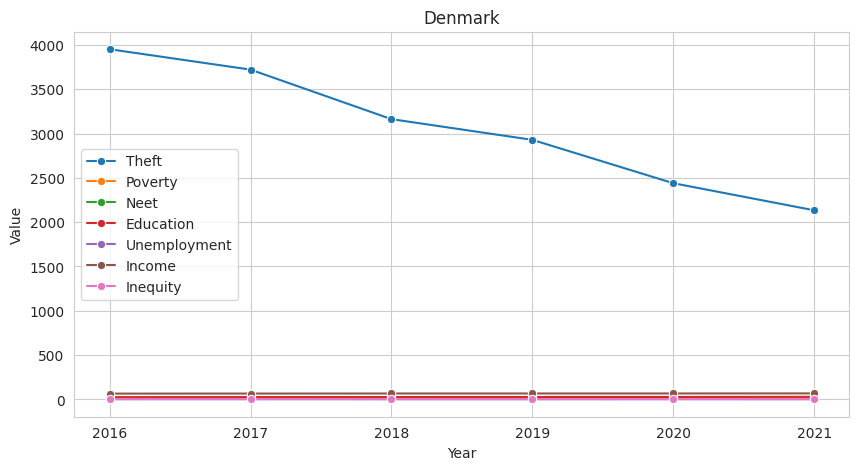

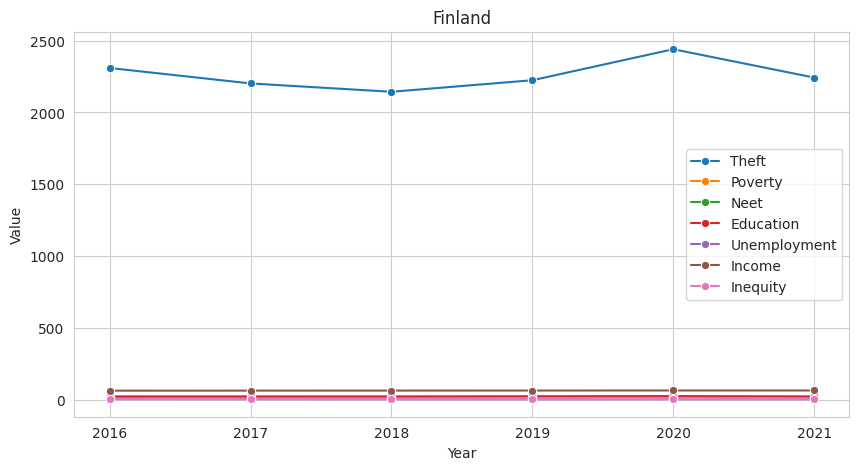

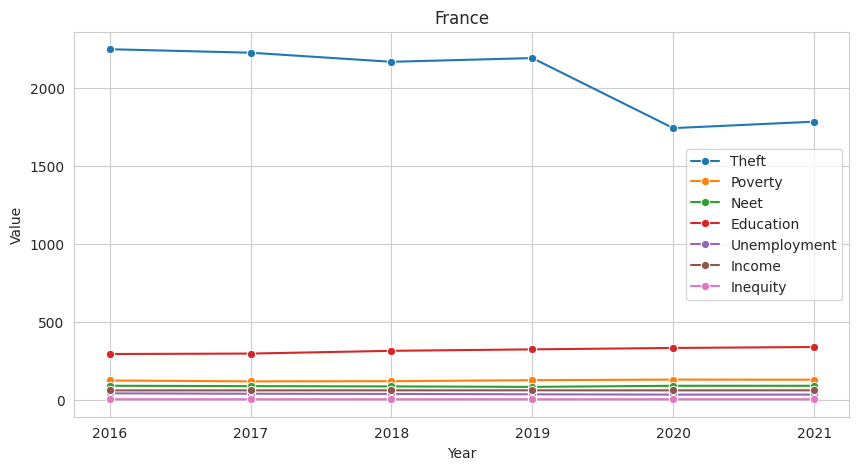

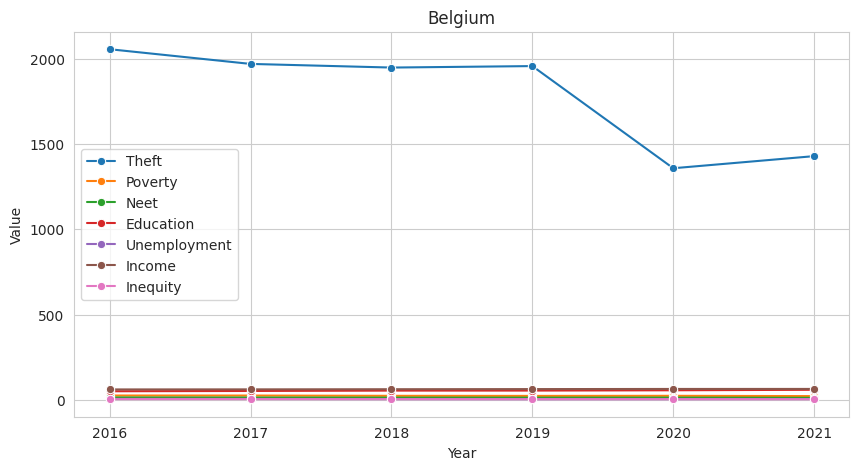

In [12]:
# Data Visualization

sweden = df[df["geo"] == "Sweden"]
denmark = df[df["geo"] == "Denmark"]
finland = df[df["geo"] == "Finland"]
france = df[df["geo"] == "France"]
belgium = df[df["geo"] == "Belgium"]

countries = [sweden, denmark, finland, france, belgium]

for country in countries:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="year", y="theft", data=country, label="Theft", marker="o")
    sns.lineplot(x="year", y="poverty", data=country, label="Poverty", marker="o")
    sns.lineplot(x="year", y="neet", data=country, label="Neet", marker="o")
    sns.lineplot(x="year", y="education", data=country, label="Education", marker="o")
    sns.lineplot(x="year", y="unemployment", data=country, label="Unemployment", marker="o")
    sns.lineplot(x="year", y="income", data=country, label="Income", marker="o")
    sns.lineplot(x="year", y="inequity", data=country, label="Inequity", marker="o")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(country["geo"].iloc[0])
    plt.show()